# **Cell clustering and Differential Expression (DE)**

---------------------------

**Motivation:**

Spermatogenesis goes through different stages, starting from *SpermatogoniaA* cells, going into clonal expansion while keeping cells connected through cytoplasmic bridges (*SpermatogoniaB*), and then continuing with the meiotic process (*Spermatocites I and II*). Finally, cells become *Round spermatids*, which then elongate to become *Elongated spermatids and sperm*.

![](https://raw.githubusercontent.com/hds-sandbox/scRNASeq_course/main/develop/python/img/spermatogenesis.png)

Detecting those cell types is essential to answer biological questions such as 
- which genes are most expressed for each cell type (beyond well known ones)?
- in which proportion is every cell type present?
- are there unknown cell types that I can identify?

---------------------------

**Learning objectives:**
- Identify potential cell clusters by visualizing marker genes on the UMAP plot
- Understanding and applying differential gene expression analysis to verify cluster identities
- Performing an analysis of subclusters in the dataset
----------------
**Execution time: 45-60 minutes**

---------------

***Import packages***

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad

plt.rcParams['figure.figsize']=(6,6) #rescale figures

Read the data integrated with `glmpca` and `bbknn`

In [2]:
sample = sc.read('../../Data/notebooks_data/sample_123.filt.norm.red.h5ad')

Only considering the two last: ['.red', '.h5ad'].
Only considering the two last: ['.red', '.h5ad'].


## Identification through marker genes

we try to identify clusters of cells by looking at the expression of relevant marker genes. This requires a previous biological knowledge of those cell types, such that we can input the markers. Below, we define a dectionary, where for each cell type we define a list of markers. Then we will plot every list of markers on the UMAP plot

In [3]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2','PRM3','AKAP4'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['VIM','CTSL']
markers['Macroph'] = ['CD14']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']

#remove markers missing in the dataset
for i in markers:
    markers[i] = np.intersect1d(markers[i], sample.var_names)

We can see how many markers easily identify groups of cells by plotting the expression

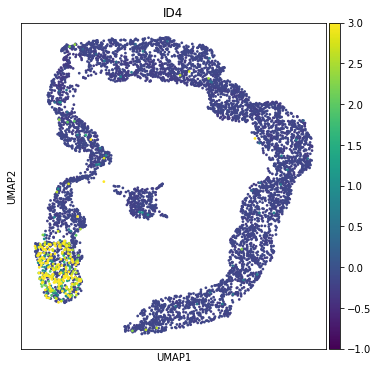

In [4]:
sc.plotting.umap(sample, color=markers['SpermatogoniaA'], vmin=-1, vmax=3, s=30)

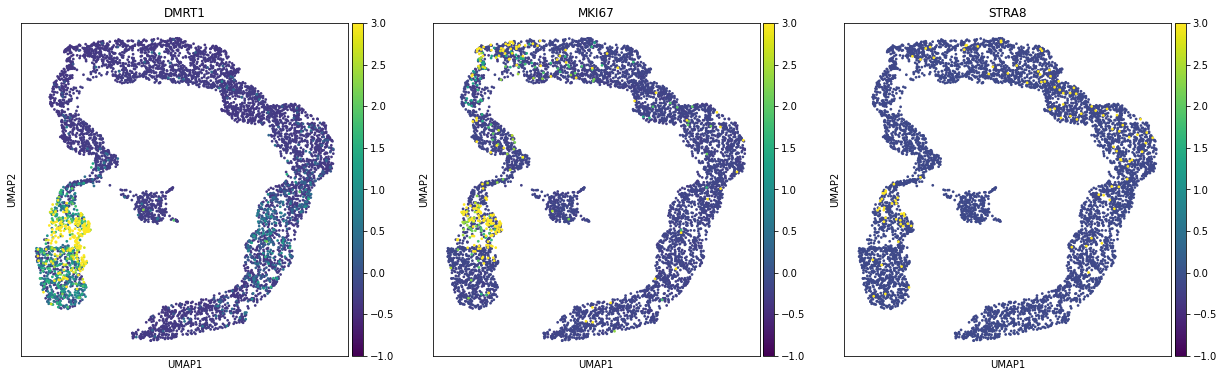

In [5]:
sc.plotting.umap(sample, color=markers['SpermatogoniaB'], vmin=-1, vmax=3, s=30)

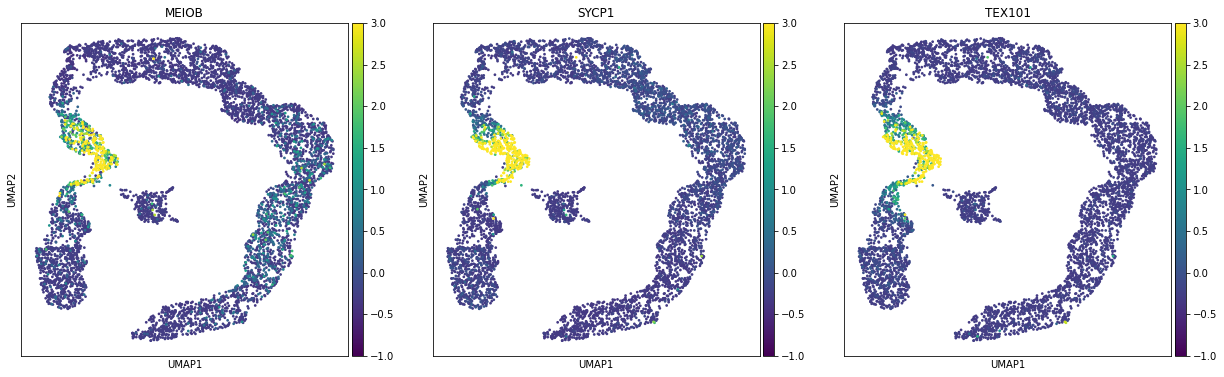

In [6]:
sc.plotting.umap(sample, color=markers['SpermatocytesI'], vmin=-1, vmax=3, s=30)

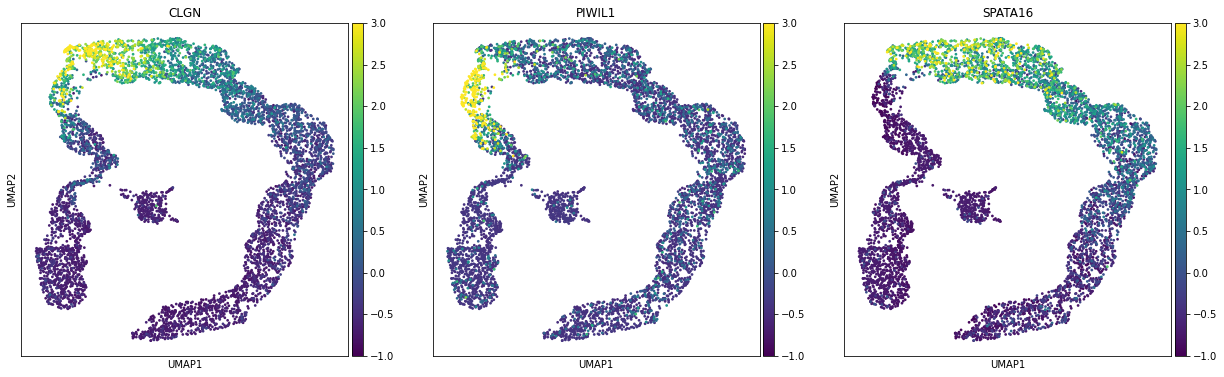

In [7]:
sc.plotting.umap(sample, color=markers['SpermatocytesII'], vmin=-1, vmax=3, s=30)

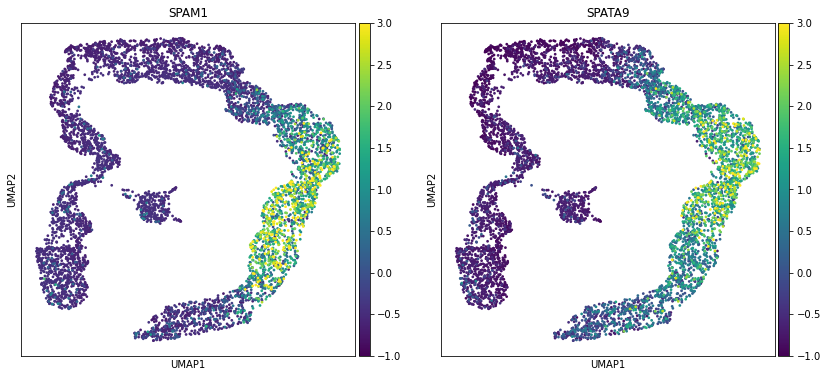

In [8]:
sc.plotting.umap(sample, color=markers['Round.Spt'], vmin=-1, vmax=3, s=30)

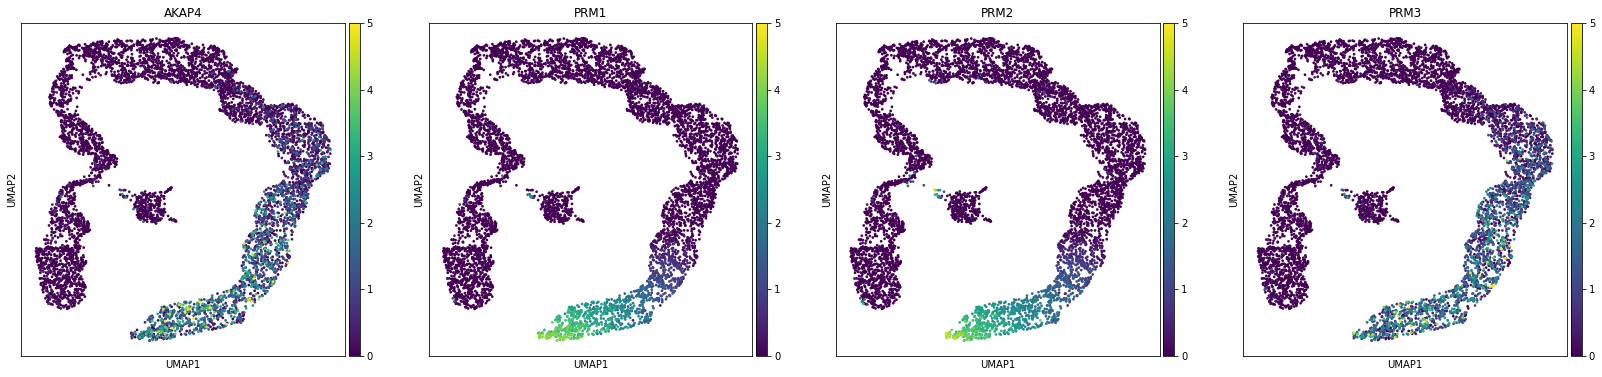

In [9]:
sc.plotting.umap(sample, color=markers['Elong.Spt'], vmin=0, vmax=5, s=30)

Sertoli are often not possible to identify. They are big in size, meaning they are often not isolated successfully. Many of their markers are in common with other somatic cells. Also, their function as nurse cells for germ cells of the testis means that their marker genes are also expressed. We can see that CTSL is expressed in some germ cells, but not in other clusters, while VIM is expressed in a likely somatic cluster (but it is common to other somatic cell types)

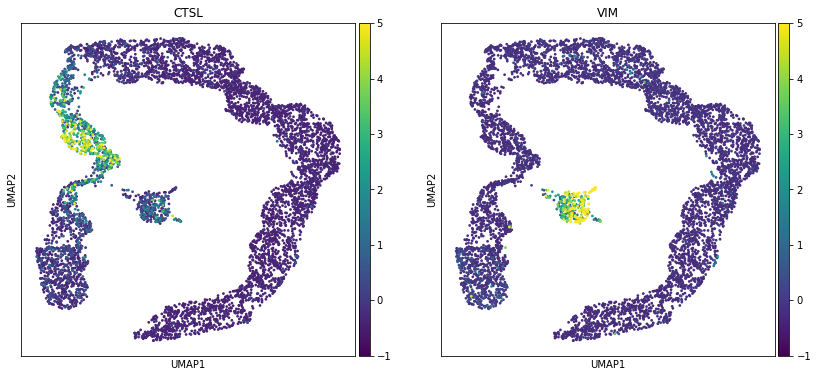

In [10]:
sc.plotting.umap(sample, color=markers['Sertoli'], vmin=-1, vmax=5, s=30)

Macrophage cells seem to be absent

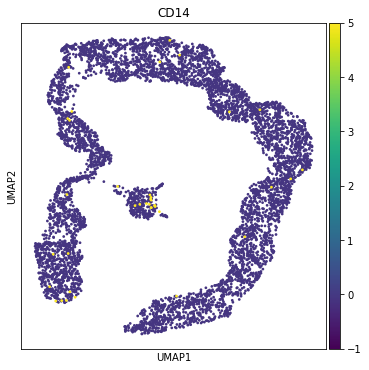

In [11]:
sc.plotting.umap(sample, color=markers['Macroph'], vmin=-1, vmax=5, s=30)

There is a little endothelial cluster

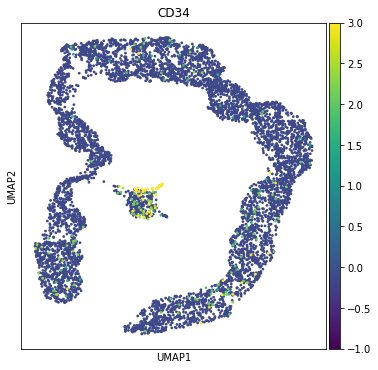

In [12]:
sc.plotting.umap(sample, color=markers['Endothelial'], vmin=-1, vmax=3, s=30)

and also a myoid cluster

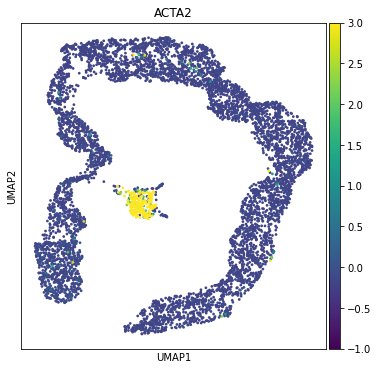

In [13]:
sc.plotting.umap(sample, color=markers['Myoid'], vmin=-1, vmax=3, s=30)

Leydig cells are likely to be missing as well

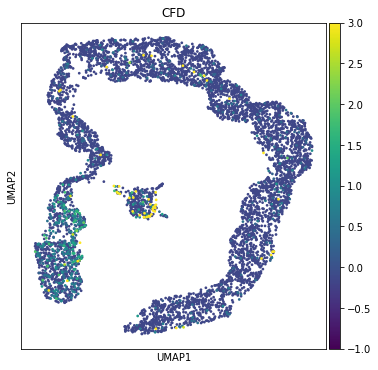

In [14]:
sc.plotting.umap(sample, color=markers['Leydig'], vmin=-1, vmax=3, s=30)

Now we create some clusters, and try to get the same division we saw by plotting markers. We can tune the number of clusters by changing the `resolution` parameter. We will be able to give the same name to more clusters, so it is fine to create a fine-grained clustering.

In [15]:
sc.tl.leiden(sample, resolution=.3, random_state=12345)

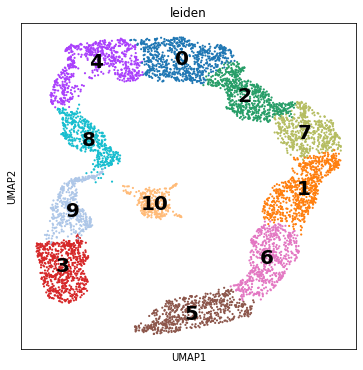

In [16]:
sc.plotting.umap(sample, color=['leiden'], legend_loc='on data', legend_fontsize=20)

Write the names in the dictionary `new_names`. You should be able to **give a name for each cell type**. Below is an example, but the names are not in the right position. If there is more than one cluster with same cell type, just write the name followed by a dot `.` and a number. For example, by writing for example `.1` and `.2` at the end of the names. We will remove the numbers afterwords.

In [17]:
clusters = pd.Categorical(sample.obs['leiden'])

In [20]:
new_names = {
    '0':'SpermatocitesII.2',
    '1':'RoundSpermatids.3',
    '2':'RoundSpermatids.4',
    '3':'SpermatogoniaA',
    '4':'SpermatocitesII.1',
    '5':'ElongSpermatids',
    '6':'RoundSpermatids.1',
    '7':'RoundSpermatids.2',
    '8':'SpermatocitesI',
    '9':'SpermatogoniaB',
    '10':'Somatic',
}

we apply the new names

In [21]:
clusters=clusters.rename_categories(new_names)

we remove the numbers from same cell types

In [22]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

save the clusters in the sample and plot the new ones

In [23]:
sample.obs['clusters']=clusters.copy()

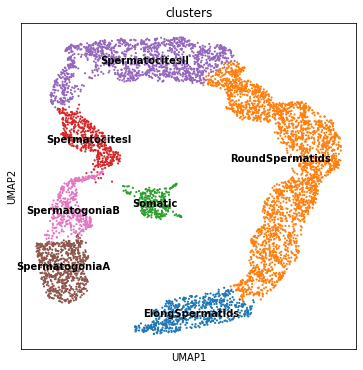

In [24]:
sc.plotting.umap(sample, color=['clusters'], legend_loc='on data')

We can look at markers in a heatmap or a dotplot

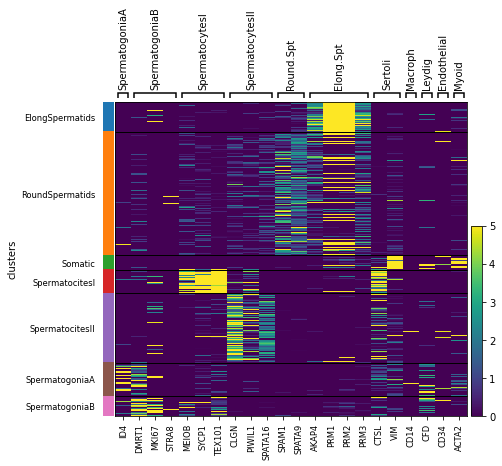

In [25]:
sc.pl.heatmap(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=5, layer='norm_sct')

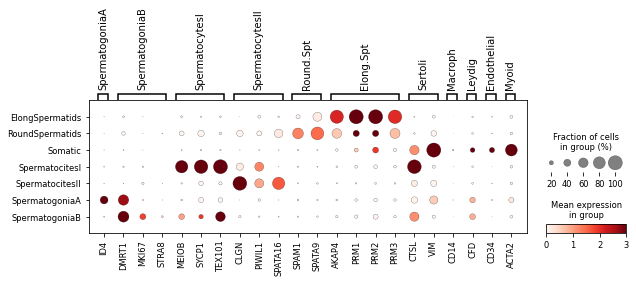

In [26]:
sc.pl.dotplot(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=3, layer='norm_sct')

In [27]:
sample.write('../../Data/notebooks_data/sample_123.filt.norm.red.clst.h5ad')

## Differential Expression (DE) analysis

We can do differential expression (DE) analysis to double check which genes are differentially expressed in each cluster. A gene is differentially expressed in a cluster when its expression in the cells of that cluster is statistically bigger than in all other cells. This is verified through a statistical test. 

Together with the gene names we also get p-values from the test, and a factor (`log-fold change`) telling the magnitude of how much the expression is larger than in other cells.

In [28]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

Apply the differential expression tool on the clusters for the top ten genes of each cluster. Save the results in `.uns[DE_clusters]`

In [29]:
sc.tl.rank_genes_groups(sample, groupby='clusters', key_added='DE_clusters', 
                        use_raw=False, n_genes=10, method='wilcoxon')

Access the list of names

In [30]:
pd.DataFrame(sample.uns['DE_clusters']['names'])

ElongSpermatids RoundSpermatids Somatic SpermatocitesI SpermatocitesII  \
0            PRM1          ERICH2   RPL10        C5orf58      AL133499.1   
1            PRM2          FNDC11     VIM           LY6K          PPP3R2   
2            TNP1           LYZL2  TMSB4X         TEX101         ZMYND10   
3       LINC01921           ACRV1  EEF1A1          TDRG1            LYAR   
4           LELP1          SPACA3    MYL6           TPTE           COPRS   
5            GLUL        C1orf185   RPL41        HORMAD1          SPINK2   
6            ODF2          ACTRT3     B2M          STMN1          MRPL34   
7        C10orf62         FAM209B    RPS8        ARL6IP1            LDHC   
8      AC010255.3           LYZL1    CD63        TMEM147          CAVIN3   
9          GAPDHS           TEX38   CALD1        C5orf47        TMEM225B   

  SpermatogoniaA SpermatogoniaB  
0          RPS12          HMGB1  
1           CCNI           PTMA  
2         DNAJB6           SMC3  
3          RPS19           NASP  
4           RPSA            VCX  
5          FKBP8          CIRBP  
6         RPL18A          TKTL1  
7         ZNF428            NCL  
8         EEF1B2         SDF2L1  
9        HNRNPDL          YWHAE

Access the table including p-values (with suffix `_P` in each column) and log-fold change (with suffix `_L` in each column)

In [31]:
result = sample.uns['DE_clusters']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
X

ElongSpermatids_N  ElongSpermatids_P  ElongSpermatids_L RoundSpermatids_N  \
0              PRM1                0.0           5.479261            ERICH2   
1              PRM2                0.0           5.263555            FNDC11   
2              TNP1                0.0           5.563935             LYZL2   
3         LINC01921                0.0           4.993138             ACRV1   
4             LELP1                0.0           3.586964            SPACA3   
5              GLUL                0.0           3.746591          C1orf185   
6              ODF2                0.0           1.980321            ACTRT3   
7          C10orf62                0.0           3.671284           FAM209B   
8        AC010255.3                0.0           3.887318             LYZL1   
9            GAPDHS                0.0           3.189089             TEX38   

   RoundSpermatids_P  RoundSpermatids_L Somatic_N      Somatic_P  Somatic_L  \
0                0.0           3.754093     RPL10  1.879383e-180   6.061464   
1                0.0           3.381924       VIM  6.626537e-180   5.904238   
2                0.0           4.095589    TMSB4X  3.038543e-179   7.129280   
3                0.0           4.410256    EEF1A1  8.509774e-179   3.155737   
4                0.0           3.781013      MYL6  4.101360e-178   4.146432   
5                0.0           4.043617     RPL41  4.101360e-178   3.012833   
6                0.0           3.629563       B2M  8.444394e-178   6.490492   
7                0.0           3.971979      RPS8  1.058438e-177   2.973517   
8                0.0           4.498296      CD63  5.158918e-177   5.339066   
9                0.0           3.211391     CALD1  5.769633e-177   6.693130   

  SpermatocitesI_N  ...  SpermatocitesI_L  SpermatocitesII_N  \
0          C5orf58  ...          4.534876         AL133499.1   
1             LY6K  ...          5.939358             PPP3R2   
2           TEX101  ...          6.329660            ZMYND10   
3            TDRG1  ...          5.709855               LYAR   
4             TPTE  ...          5.262171              COPRS   
5          HORMAD1  ...          3.822508             SPINK2   
6            STMN1  ...          2.181750             MRPL34   
7          ARL6IP1  ...          3.732162               LDHC   
8          TMEM147  ...          3.188939             CAVIN3   
9          C5orf47  ...          3.403830           TMEM225B   

  SpermatocitesII_P  SpermatocitesII_L  SpermatogoniaA_N SpermatogoniaA_P  \
0               0.0           3.951918             RPS12              0.0   
1               0.0           2.925693              CCNI              0.0   
2               0.0           3.068692            DNAJB6              0.0   
3               0.0           3.380893             RPS19              0.0   
4               0.0           3.012631              RPSA              0.0   
5               0.0           2.506658             FKBP8              0.0   
6               0.0           3.766496            RPL18A              0.0   
7               0.0           2.803699            ZNF428              0.0   
8               0.0           3.651773            EEF1B2              0.0   
9               0.0           2.711139           HNRNPDL              0.0   

   SpermatogoniaA_L  SpermatogoniaB_N SpermatogoniaB_P  SpermatogoniaB_L  
0          3.358225             HMGB1    5.695630e-232          4.110899  
1          5.022986              PTMA    2.289016e-230          4.592574  
2          4.119973              SMC3    6.352623e-220          4.531697  
3          3.611154              NASP    5.771049e-216          3.862513  
4          4.187228               VCX    2.471442e-215          4.379521  
5          2.255552             CIRBP    3.932801e-205          3.970943  
6          4.925106             TKTL1    4.225019e-205          4.495093  
7          3.834186               NCL    1.175944e-200          4.035778  
8          2.871610            SDF

We can easily save the table in csv format. This can be opened in Excel.

In [32]:
!mkdir -p ../../Data/results

In [33]:
X.to_csv('../../Data/results/diff_expression_clusters.csv', header=True, index=False)

## Subclustering the data

We find subclusters of cells using markers for cell types that are found between late spermatogonia and spermatocites.

In [34]:
#Clusters to be subsetted
SUBGROUPS = ['SpermatogoniaB','SpermatocitesI','SpermatocitesII'] 

In [35]:
#Markers for the processes involved in late spermatogonia and spermatocites
markers['Leptotene'] = ['SYCE2','SCML1']
markers['Zygotene'] = ['LY6K', 'SYCP1']
markers['Pachytene'] = ['PIWIL1','CCDC112']
markers['Diplotene'] = ['OVOL2','CCNA1', 'CDK1','AURKA']

Let's look at the markers plottes only over the cells of the clusters `SpermatogoniaB`, `SpermatocitesI` and `SpermatocitesII`

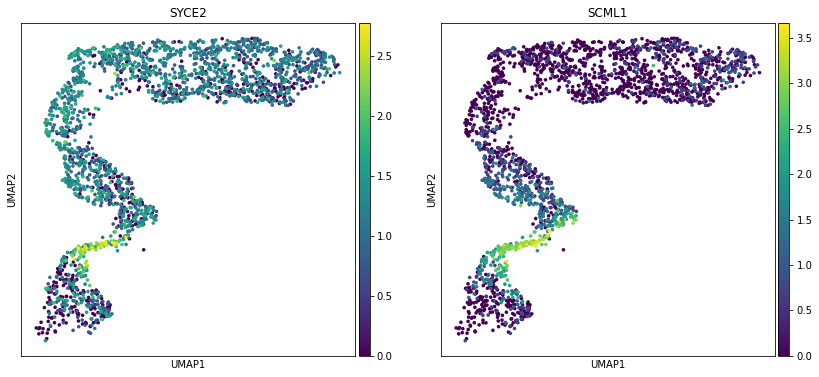

In [36]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Leptotene'])

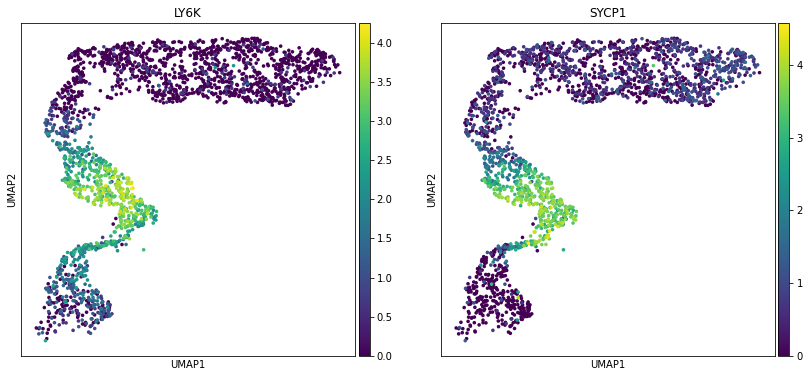

In [37]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Zygotene'])

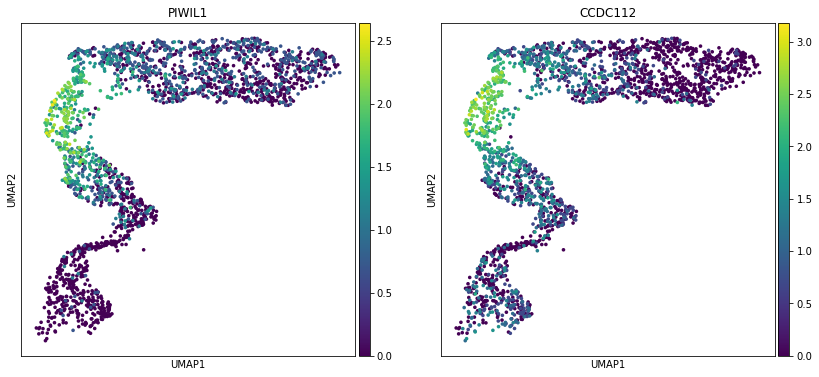

In [38]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Pachytene'])

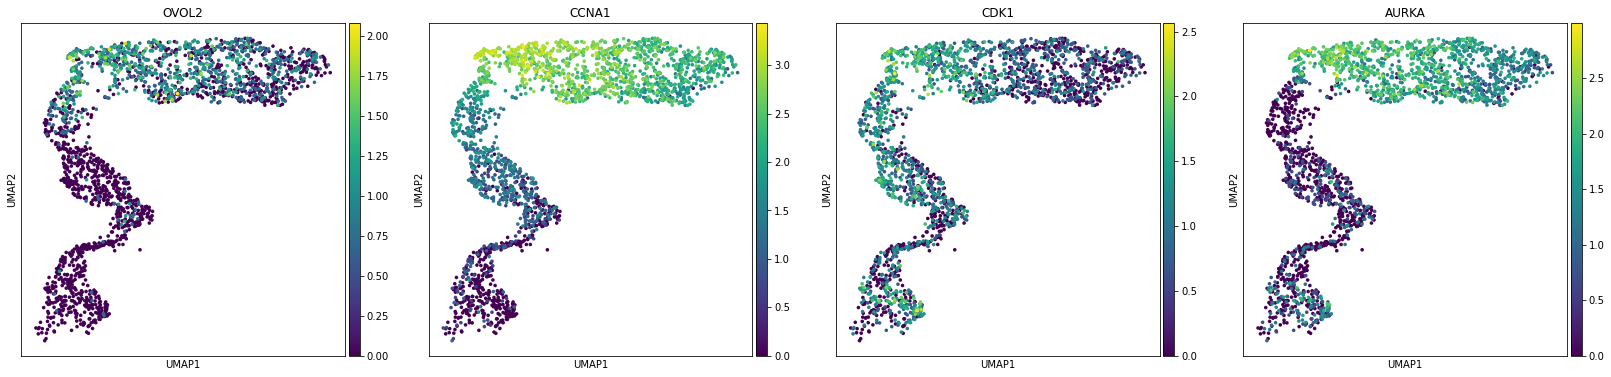

In [39]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Diplotene'])

We want to create new clusters in our dataset by starting from the old clustering. To do this we use the option `restrict_to`, where we write the name of the old clustering, and the name of which clusters we want to subset. Try to tune the resolution to have a proper number of clusters to rename.

In [48]:
sc.tl.leiden(sample, resolution=.4, key_added='clusters_spc',
            restrict_to=('clusters', SUBGROUPS),
            random_state=12345)

Let's look at the new clustering of `spermatogoniaB` and `spermatocites I/II`

Trying to set attribute `.uns` of view, copying.


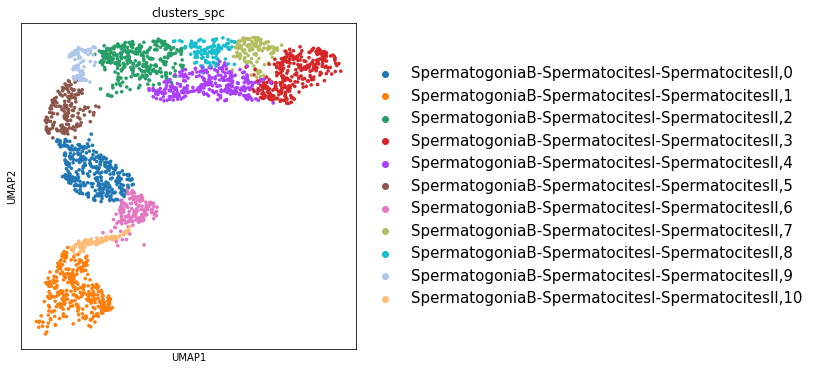

In [49]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_fontsize=15)

Names are very long. We keep only the numbers at the end

In [50]:
clusters = sample.obs['clusters_spc']
cluster_array = np.array(clusters)
split_array = [ i.split(',')[1] if ',' in i else i for i in cluster_array]
clusters = pd.Categorical(split_array)
sample.obs['clusters_spc']=clusters.copy()

Trying to set attribute `.uns` of view, copying.


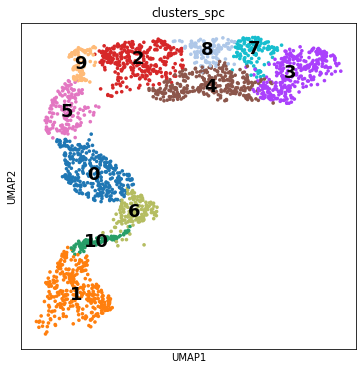

In [51]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_loc='on data', legend_fontsize=18)

Before renaming, we also want to look at the differentially expressed genes. We should be able to find at least some of the markers used in the plots. However, it can be that those do not appear because there are many other coexpressed genes with high expression values.

In [52]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

In [53]:
sc.tl.rank_genes_groups(sample, groupby='clusters_spc', key_added='DE_clusters_spc',
                        use_raw=False, n_genes=20, method='wilcoxon')

We can find some of the marker genes. For example `SCML1` for leptotene cells, `SYCP1` and `LY6K` for zygotene, `CCDC112` and `PIWIL1` for pachitene, `CCNA1` and `AURKA` for zygotene. 

In [54]:
pd.DataFrame(sample.uns['DE_clusters_spc']['names'])

0        1        10           2           3           4  \
0         TPTE     PTMA      DPH7     NDUFAF3      CDRT15  AL133499.1   
1      C5orf58    HMGB1     SCML1      PPP3R2      SLC51B       SNRPC   
2       TMEM99    CIRBP      SMC3      ASRGL1      CCDC42      FBXO25   
3   AC044839.1     CFL1     SMC1B       CCNA1      ETFRF1        GYG1   
4         LY6K    TKTL1    ZCWPW1  AL133499.1       TBPL1        LDHC   
5        GIHCG  TRMT112       VCX     CIAPIN1        CT66      UQCR10   
6        H2AFZ     NASP     VCX3B        LDHC       SNRPC     ZMYND10   
7       SPATA8     SMC3     SYCP3       COPRS   MCHR2-AS1       COPRS   
8        TDRG1    HMGN2     VPS29     ZMYND10    C16orf95    CATSPERZ   
9       PRSS21    PRAME     TEX19        GYG1       CCNB2     ZC2HC1C   
10     ARL6IP1      VCX     CLSPN      MRPL34      GTF2A2         UBB   
11       CALM2    YWHAE     HPRT1        CLGN    C9orf116       ISOC2   
12        CKLF      NCL     INCA1        LYAR        PIFO       CCNA1   
13       STMN1    RNPS1  HIST1H4C      CAVIN3        GOT1        RAE1   
14     HORMAD1   CHCHD2     HMGB2        RAE1      CAVIN3       APH1B   
15      TEX101    CCT6A    SDF2L1       ISOC2  AL133499.1       H2AFJ   
16     TMEM147     RBM3     TAF12      SPINK2       PSMG1      CAVIN3   
17        TBCA     BTG3   ZCCHC17  AC002467.1      MRPS15       TBPL1   
18       H3F3B     LSM4     PAGE1       APH1B       ZNRD1         PBK   
19        CTSL   GAGE2A     PRAP1       REXO5     CFAP126        CLGN   

             5        6           7           8           9 ElongSpermatids  \
0     C15orf48   TEX101      GTF2A2       TBPL1      PPP3R2            PRM1   
1      CCDC112   ZCWPW1      CCDC42      CCDC42     CIAPIN1            PRM2   
2         PHF7    SYCP1       CCNB2        GYG1        LYAR            TNP1   
3       MGAT4D  SELENOT       TBPL1      CAVIN3      ASRGL1       LINC01921   
4        CETN3     RHEB      TMIGD3       ISOC2       GULP1           LELP1   
5       COX7A2  C5orf47      ETFRF1        LDHC        AARD            GLUL   
6        GIHCG     LY6K    C16orf95       CCNB2  AC005041.4            ODF2   
7       CFAP53     NPC2      SLC51B       CCNA1  AC016747.1        C10orf62   
8       RPL39L    EIF1B      MRPL43     ZC2HC1C      CAVIN3      AC010255.3   
9   AC008771.1   DYNLL1       SNRPC      ETFRF1    SLC25A19          GAPDHS   
10     FAM174A   FMR1NB       PTTG1    C16orf95      AKAP12         P3R3URF   
11   STIM2-AS1  HORMAD1      CAVIN3       CCT6B        MRM3           TSSK6   
12        ARL3    TDRG1        CT66      COMMD8       TKTL2         DCUN1D1   
13      PIWIL1    KIF5B      SCCPDH      MRPL34    C15orf48           HMGB4   
14       RNFT1    SYCP3       ISOC2  AC002467.1     ZMYND10          SPATA3   
15      BCAP29     SMC3       KPNA5       AURKA     NDUFAF3           TEX44   
16      MLLT10  HSP90B1      CDRT15  AL133499.1        RGCC           TEX37   
17      TMEM99  C5orf58       H2AFJ      MRPL43      POU5F2            OAZ3   
18        PENK    STMN1  AL133499.1       ZPBP2         KLB           FNDC8   
19     MORF4L1   DMRTC2       PSMG1         PBK       GMCL2           IQCF1   

   RoundSpermatids  Somatic SpermatogoniaA  
0           ERICH2    RPL10          RPS12  
1           FNDC11      VIM           CCNI  
2            LYZL2   TMSB4X         DNAJB6  
3            ACRV1   EEF1A1          RPS19  
4           SPACA3     MYL6           RPSA  
5         C1orf185    RPL41          FKBP8  
6           ACTRT3      B2M         RPL18A  
7          FAM209B     RPS8         ZNF428  
8            LYZL1     CD63         EEF1B2  
9            TEX38    CALD1        HNRNPDL  
10          SPACA7   RPL13A          YWHAB  
11         FAM209A      MGP         TUBA1B  
12            EQTN   MALAT1           RPS5  
13           TEX33   TMSB10          EGFL7  
14           AFG1L      FTL         LYPLA1  
15           SESN3    RPS4X          RPS21  
16          SPACA4   RPL10A          RPLP0  
17       

We can again look at p-values and log-fold changes

In [55]:
result = sample.uns['DE_clusters_spc']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

and save the table

In [56]:
X.to_csv('../../Data/results/diff_expression_subclusters.csv', header=True, index=False)

We can look at only the columns of a cluster from the large table so it is more readable

In [57]:
X[ ['7_N','7_L','7_P'] ]

7_N       7_L           7_P
0       GTF2A2  1.713210  2.454507e-54
1       CCDC42  2.881220  7.724417e-54
2        CCNB2  2.298391  5.539823e-51
3        TBPL1  2.151057  1.737986e-50
4       TMIGD3  2.112299  2.285057e-49
5       ETFRF1  2.278255  3.827467e-49
6     C16orf95  2.109850  5.745663e-49
7       SLC51B  2.715796  1.477458e-47
8       MRPL43  2.184598  1.477458e-47
9        SNRPC  2.202506  2.360302e-47
10       PTTG1  1.975605  2.765424e-47
11      CAVIN3  2.772689  4.681643e-47
12        CT66  2.155308  1.182636e-46
13      SCCPDH  1.568190  1.712657e-46
14       ISOC2  2.652072  2.530819e-46
15       KPNA5  2.494994  2.650060e-46
16      CDRT15  2.618294  2.650060e-46
17       H2AFJ  1.601331  3.370764e-46
18  AL133499.1  3.074455  3.370764e-46
19       PSMG1  1.719448  3.967144e-46

We rename the new clusters. Write the names in the dictionary. Some of the clusters might still be `SpermatogoniaB` or `SpermatocitesII` as before.

In [58]:
clusters = pd.Categorical(sample.obs['clusters_spc'])

In [59]:
new_names = {
    '0':'Zygotene.1',
    '1':'SpermatogoniaB',
    '2':'Diplotene.1',
    '3':'Diplotene.2',
    '4':'Diplotene.3',
    '5':'Pachytene',
    '6':'Zygotene.2',
    '7':'Diplotene.4',
    '8':'Diplotene.5',
    '9':'Diplotene.6',
    '10':'Leptotene'
}

In [60]:
clusters=clusters.rename_categories(new_names)

In [61]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

In [62]:
sample.obs['clusters_spc']=clusters.copy()

Just a plot of the two clustering side by side

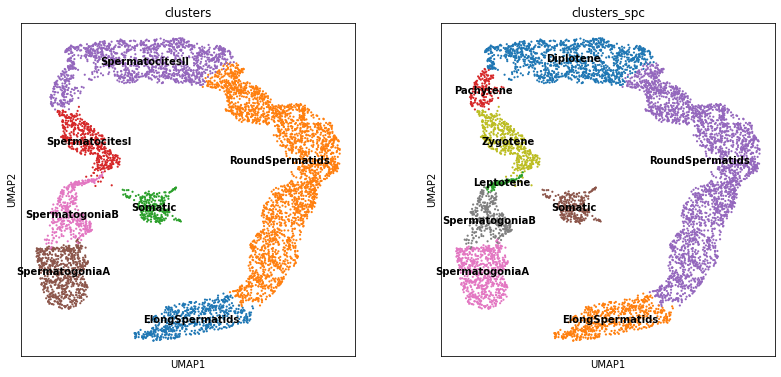

In [63]:
sc.plotting.umap(sample, color=['clusters','clusters_spc'], legend_loc='on data')

It isn't really clear how to rename clusters in somatic cells. We let them be called `somatic` without further specification

You can plot the correlation matrix of the clusters with a dendrogram tree on the left side. Note how round and elongated spermatids are largely separated from the rest of the data. Spermatogonias are very similar to each other and could maybe reduced into a single cluster. 

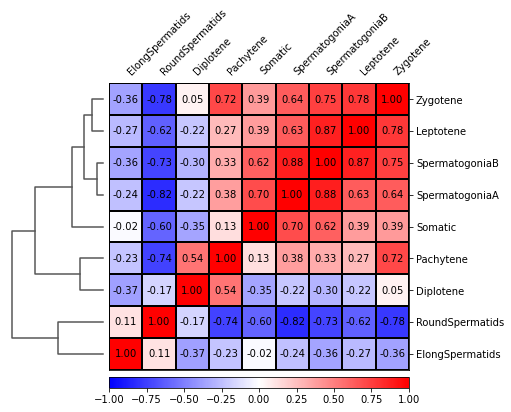

In [64]:
sc.pl.correlation_matrix(sample, groupby='clusters_spc', 
                         show_correlation_numbers=True)

Look at the proportion of each cell type in the data

In [65]:
#number of cells
sample.obs['clusters_spc'].value_counts()

RoundSpermatids    2521
Diplotene          1248
SpermatogoniaA      683
ElongSpermatids     618
Zygotene            483
SpermatogoniaB      328
Somatic             295
Pachytene           168
Leptotene            87
Name: clusters_spc, dtype: int64

In [66]:
#Percentage of cells
sample.obs['clusters_spc'].value_counts() / sample.shape[0] * 100

RoundSpermatids    39.200746
Diplotene          19.406002
SpermatogoniaA     10.620432
ElongSpermatids     9.609703
Zygotene            7.510496
SpermatogoniaB      5.100295
Somatic             4.587156
Pachytene           2.612346
Leptotene           1.352822
Name: clusters_spc, dtype: float64

finally, save the data

In [67]:
sample.write('../../Data/notebooks_data/sample_123.filt.norm.red.clst.2.h5ad')

## Wrapping up

We have been showing how to simply identify potential cell clusters. At least in this dataset, the cells change from one type to another in a continuous process, so such a hard clustering does not completely reflect biological reality. However, it is a good approximation, as it is illustrated by the differentially expressed genes we could check in each cluster.
We introduced how to perform differential expression, and what are the useful values that we get from it (p-value of the test, magnitude of the gene expression compared to all other clusters). Finally, we subsetted the data into a more fine grained cell identification.